# UMA Raw data EDA

## Import Libraries

In [1]:
# analysis
import numpy as np
import pandas as pd
import json

# other
import warnings
import os
import requests

# visualisation libraries
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
import seaborn as sns

# Notebook styling
%matplotlib inline
sns.set(style='whitegrid', palette='muted',
        rc={'figure.figsize': (15,10)})
warnings.filterwarnings("ignore")


In [2]:

# credentials_file_loc = "../../../../Admin/authentication_files/uma_api_cred_2021-01-21.json"
# with open(credentials_file_loc , "r") as read_file:
#     data = json.load(read_file)
# data

## Define Helper Functions

In [3]:
def get_api_token(credentials_file_loc):
    """
    This function makes a POST request to Gometro's UMA REST API and returns a valid api token
    
    ------------------------------------
    Parameters:
        credentials_file_loc (str): 
        date (str): column name of field containing the payload of the data
    
    Returns: (str): 
    ------------------------------------
    Example:
    
    
    
    """
    
    # get dictionary of authorisation credentials
    with open(credentials_file_loc , "r") as read_file:
        task = json.load(read_file)
    
    # make api request
    endpoint = 'https://identity.gometroapp.com/auth/realms/platform/protocol/openid-connect/token'
    response = requests.post(endpoint, data=task)
    
    # catch error
    if (response.status_code < 200) and (response.status_code >= 300):
        raise ValueError('POST /tasks/ {}'.format(response.status_code))
    
    return response.json()["access_token"]
    
    

In [4]:
def get_raw_user_data(pid, date, token):
    
    """
    This function makes a GET request to Gometro's UMA REST API and returns data from
    the API.
    
    ------------------------------------
    Parameters:
        participant_id (str): column name of field containing the payload of the data
        date (str): column name of field containing the payload of the data
    
    Returns: (pandas.DataFrame): Dataframe with payload data in each column
    ------------------------------------
    Example:
    
    
    
    """
    
    # define API headers
    headers = {'Authorization': f'Bearer {token}'}
    
    # make api request    
    endpoint = f'https://api.gometroapp.com/uma/v1/participants/{pid}/events/{date}'
    response = requests.get(endpoint, headers=headers)
    
    # catch error
    if (response.status_code < 200) and (response.status_code >= 300):
        raise ValueError('GET /tasks/ {}'.format(response.status_code))
    
    # import data
    assert len(response.json()) > 0, "response returned no data"
    df = pd.DataFrame(response.json())
    
    # select location data
    return df[df['type'] == 'LocationChanged']
    

In [5]:
def choose_raw_data_type(pid, date, token, data_type):
    
    """
    This function makes a GET request to Gometro's UMA REST API and returns data from
    the API.
    
    ------------------------------------
    Parameters:
        participant_id (str): column name of field containing the payload of the data
        date (str): column name of field containing the payload of the data
    
    Returns: (pandas.DataFrame): Dataframe with payload data in each column
    ------------------------------------
    Example:
    
    
    
    """
    
    # define API headers
    headers = {'Authorization': f'Bearer {token}'}
    
    # make api request    
    endpoint = f'https://api.gometroapp.com/uma/v1/participants/{pid}/events/{date}'
    response = requests.get(endpoint, headers=headers)
    
    # catch error
    if (response.status_code < 200) and (response.status_code >= 300):
        raise ValueError('GET /tasks/ {}'.format(response.status_code))
    
    # import data
    assert len(response.json()) > 0, "response did not return any data"
    df = pd.DataFrame(response.json())
    
    # select location data
    return df[df['type'] == data_type]

In [6]:
def unpack_payload(df, payload_col = 'payload'):
    
    """
    This function takes a dataframe where the payload is in one column
    and creates a new column for each element in the payload
    
    ------------------------------------
    Parameters:
        df (pandas.DataFrame): DataFrame containing column with payload
        payload_col (str): column name of field containing the payload of the data
    
    Returns: (pandas.DataFrame): Dataframe with payload data in each column
    ------------------------------------
    Example:
    
    
    """
    
    # make copy of dataframe
    df = df.copy()
    
    # import literal_eval function
    from ast import literal_eval

    # make list of column headers from keys
    payload_cols = literal_eval(df['payload'].iloc[0]).keys()
    
    # add columns for each column header to dataframe
    for col in payload_cols:
        df[col] = df['payload'].apply(lambda x: literal_eval(x)[col])
        
    # remove type and payload column
    df.drop(['type', 'payload'], axis=1, inplace=True)
    
    return df



In [7]:
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    this funtion takes the coordinates between two points and returns
    the distance between the points of the given coordinates in meters.
    
    ------------------------------------
    Parameters:
        lat1 (float): latitude of first point
        lat1 (float): longitude of first point
        lat1 (float): latitude of second point
        lat1 (float): longitude of second point
    
    Returns: (float): distanctance between points (m)
    
    ------------------------------------
    source: https://towardsdatascience.com/heres-how-to-calculate-distance-between-2-geolocations-in-python-93ecab5bbba4
    
    ------------------------------------
    Example:
    
    

    """
    # define constants
    r = 6371
    
    # implement haversine formula
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2
    res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))
    
    # convert result to from km to m
    res = res * 1000
    
    return np.round(res, 2)

In [8]:
def prep_data_raw(df):
    
    """
    This function takes data unpacked from GoMetro's UMA REST API using the
    unpack_payload function and returns a dataframe with the following columns
    added to the data
    
    ------------------------------------
    Parameters:
        df (pandas.DataFrame): DataFrame containing column with payload
    
    Returns: (pandas.DataFrame): Dataframe with payload data in each column
    ------------------------------------
    Example:
    
    
    """
    
    # make copy of dataframe
    df = df.copy()
    
    # convert timetamps to date time
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # shift coordinates
    df['lat_shift'] = df['latitude'].shift(-1)
    df['lon_shift'] = df['longitude'].shift(-1)

    
    # add features
    df['time_change'] = df['timestamp'].diff().dt.seconds
    df['speed_change'] = df['speed'].diff()
    df['acceleration'] = df['speed_change']/df['time_change']
    df['cumm_acceleration'] = df['acceleration'].cumsum()
    df['distance'] = df.apply(lambda x:
                              haversine_distance(x['latitude'],
                                                 x['longitude'],
                                                 x['lat_shift'],
                                                 x['lon_shift']), axis=1)
    
    df['cumm_distance'] = df['distance'].cumsum()
    df.drop(['lat_shift', 'lon_shift'], axis=1, inplace=True)
    
    # make timestamp index
    df = df.set_index('timestamp')
    
    return df

In [9]:
def add_label_units(label):
    """
    This function generates a label with units
    ------------------------------------
    Parameters:
        label (str): column name of field we want units for
    
    Returns:
        (str): column name of field with the units such that '<label> (<unit>)'
    ------------------------------------
    Example:
    
    """
    
    # define dictionary of units for known column names
    units_dict = {'speed': 'm/s',
                  'acceleration': 'm/$s^{2}$',
                  'cumm_acceleration': 'm/$s^{2}$',
                  'bearing': '$&deg;$',
                  'latitude': '$&deg;$',
                  'longitude': '$&deg;$',
                  'accuracy': 'm',
                  'distance': 'm'
                  }
    
    # return units for known column names
    if label in units_dict.keys():
        return f'{label} [{units_dict[label]}]'
    
    # return label for unknown colum names
    return label

In [10]:
def raw_trip_analysis_plot(df, col, participant_id, date, trip_id, figures_dir):
    
    """
    This function was created to plot a line graph of a numerical variable over a day
    
    ------------------------------------
    Parameters:
        df (pandas.DataFrame):
        col (str):
        participant_id (str):
        date (str):
        trip_id (int):
        figures_dir (str)
     
    ------------------------------------
    Example:
    
    """
    
    # 1. set size of figure
    fig, ax = plt.subplots(figsize=(400,10))
    
    
    # 2. plot figure
    ax.plot(df.loc[date][col], linestyle='-', color='b')

                        
    # 3. format figure
    # 3.1 set title of figure
    ax.set_title(f"{col} profile over time on {date}")
    
    # 3.2 set y_label
    ax.set_ylabel(add_label_units(col))
    
    # 3.3 set x_label
    ax.set_xlabel('time [24hrs]')
    
    # 3.4 set x-axis ticks to 1 min intervals
    xlocator = mdates.MinuteLocator(interval = 1)
    ax.xaxis.set_major_locator(xlocator)
    
    ## Format xtick labels as HH:MM
    xformatter = mdates.DateFormatter('%H:%M')
    plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)
    
    # plt.xticks(rotation=90)
    plt.setp(ax.get_xticklabels(), rotation=90, ha='right')
    
    # 4.a define path
    file_path = os.path.join(figures_dir, participant_id, f'{trip_id}_{date}_{col}_vs_time')
    
    # 4.b ensure that path directory exists
    file_dir = os.path.join(figures_dir, participant_id)
    if not os.path.exists(file_dir):
        os.mkdir(file_dir)
    
    # 5 save figure
    plt.savefig(file_path)
    
    # 6 display figure
    plt.show()

In [11]:
def plot_category_distribution(df, category, value, participant_id, date, trip_id,
                               figures_dir, plot_type=sns.violinplot):
    
    """
    To create a distribution plot. The standard plot type is violing plot.
    
    ------------------------------------
    Parameters:
        df (pandas.DataFrame):
        category (str):
        value (str):
        plot_type (seaborn.categorical):
        participant_id (str):
        trip_id (int):
        figures_dir (str)
     
    ------------------------------------
    Example:
    
    
    """
    
    # Create bee swarm plot with Seaborn's default settings
    _ = plot_type(x=category, y=value, data=df)

    # Label Title and axes
    _ = plt.title(f'distribution of {category} vs {value} on {date}')
    _ = plt.xlabel(category)
    _ = plt.xticks(rotation=90)
    _ = plt.ylabel(value)
    
    # 4.a define path
    file_path = os.path.join(figures_dir, participant_id, f'{trip_id}_{date}_violinPlot_{category}_vs_{value}')
    
    # 4.b ensure that path directory exists
    file_dir = os.path.join(figures_dir, participant_id)
    if not os.path.exists(file_dir):
        os.mkdir(file_dir)
    
    # save the plot
    plt.savefig(file_path)

    # Show the plot
    plt.show()

## Import Data

In order to get the satellite count data:

1. define the required trip information:
    * `pid` - participant id
    * `trip_date` - the date the participant made the trip
    * `jira_trip_id` - trip number allocated in Jira
1. get a valid UMA API token using the `get_api_token` function
1. download the raw satellite count response using the `choose_raw_data_type` function

In [12]:
# get trip info
pid = '0ab124d9-edd9-410e-ab72-9fb8ffc7cedd'
trip_date = '2021-01-15'
jira_trip_id = 25

In [13]:
# get token to access api
credentials_file_loc = "../../../../../Admin/authentication_files/uma_api_cred_2021-01-21.json"
token = get_api_token(credentials_file_loc)
token

'eyJhbGciOiJSUzI1NiIsInR5cCIgOiAiSldUIiwia2lkIiA6ICJXOEJqLU9Yd2VUNm5jNGNmRmxTYkJKM0hCdTdESGlfeXo5WjdaZGc0c1g0In0.eyJleHAiOjE2MjE4NTc0MzUsImlhdCI6MTYyMTg1NzEzNSwianRpIjoiNWVkZmIyZTUtM2IxMi00OWViLWJlOTUtZGVjZjIzMDdjNzIwIiwiaXNzIjoiaHR0cHM6Ly9pZGVudGl0eS5nb21ldHJvYXBwLmNvbS9hdXRoL3JlYWxtcy9wbGF0Zm9ybSIsImF1ZCI6ImFjY291bnQiLCJzdWIiOiJiNDc0MjE4ZS0zNTM1LTQ1MTQtYjBiNy02YTI3ODIzNmFjMjMiLCJ0eXAiOiJCZWFyZXIiLCJhenAiOiJnb21ldHJvLXVtYS1zZXJ2aWNlIiwic2Vzc2lvbl9zdGF0ZSI6ImI3MTNhNDA1LTE4NGMtNDBjZC04OWVhLTMyYTA0MTc3YTI5ZSIsImFjciI6IjEiLCJyZWFsbV9hY2Nlc3MiOnsicm9sZXMiOlsib2ZmbGluZV9hY2Nlc3MiLCJzeXN0ZW1fYWRtaW4iLCJ1bWFfYXV0aG9yaXphdGlvbiJdfSwicmVzb3VyY2VfYWNjZXNzIjp7ImFjY291bnQiOnsicm9sZXMiOlsibWFuYWdlLWFjY291bnQiLCJtYW5hZ2UtYWNjb3VudC1saW5rcyIsInZpZXctcHJvZmlsZSJdfX0sInNjb3BlIjoicHJvZmlsZSBlbWFpbCIsImVtYWlsX3ZlcmlmaWVkIjpmYWxzZSwicHJlZmVycmVkX3VzZXJuYW1lIjoiZ29tZXRyby1zeXN0ZW0tYWRtaW4ifQ.hDE3GLhvsOaxOnz63jJFN6lVt9QmcCfijs9w-51a0jYdmJRG8FPqL3pst2yGrpiJUWCjrrArMgObEtc6T-C46BX9bBHh2iS2xz2lxYaycvLrRC2SS5Ae

### Satellite Counts

In [14]:
data_type = 'SatelliteStatusChanged'

df_satCount_resp = choose_raw_data_type(pid, trip_date, token, data_type)
print(df_satCount_resp.shape)
print(df_satCount_resp.info())
df_satCount_resp.head()

AssertionError: response did not return any data

### Accuracy

In [ ]:
data_type = 'LocationChanged'

df_locChange_resp = choose_raw_data_type(pid, trip_date, token, data_type)
print(df_locChange_resp.shape)
print(df_locChange_resp.info())
df_locChange_resp.head()

## Transform Data

1. parse the satellite count data using the `unpack_payload` function
1. convert timestamp to datetime and make it the index of the dataframe

### Satellite Count Data

In [170]:
# unpack payload into dataframe
df_satCount_raw = unpack_payload(df_satCount_resp)

# make datafrme with datetime index
df_satCount_raw['timestamp'] = pd.to_datetime(df_satCount_raw['timestamp'])
df_satCount_raw = df_satCount_raw.set_index('timestamp')

# preview data
print(df_satCount_raw.shape)
print(df_satCount_raw.info())
df_satCount_raw.head()

(382, 1)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 382 entries, 2021-01-15 09:12:43.407000+00:00 to 2021-01-15 22:25:59.886000+00:00
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   satelliteCount  382 non-null    int64
dtypes: int64(1)
memory usage: 6.0 KB
None


satelliteCount
timestamp                                       
2021-01-15 09:12:43.407000+00:00               0
2021-01-15 10:02:19.584000+00:00               1
2021-01-15 10:31:28.786000+00:00               0
2021-01-15 10:31:39.756000+00:00               3
2021-01-15 10:31:50.738000+00:00               7

In [194]:
df_satCount_raw.loc['2021-01-15 14:50': '2021-01-15 15:10']

satelliteCount
timestamp                                       
2021-01-15 14:51:09.418000+00:00               0
2021-01-15 14:51:23.768000+00:00              19
2021-01-15 14:51:33.845000+00:00              20
2021-01-15 14:51:44.836000+00:00              28
2021-01-15 14:51:55.781000+00:00              26
2021-01-15 14:52:06.782000+00:00              27
2021-01-15 14:52:17.815000+00:00              28
2021-01-15 14:52:27.817000+00:00              27
2021-01-15 14:52:37.821000+00:00              26
2021-01-15 14:52:48.824000+00:00              25
2021-01-15 14:52:59.810000+00:00              27
2021-01-15 14:53:10.817000+00:00              26
2021-01-15 14:53:21.813000+00:00              28
2021-01-15 14:53:31.824000+00:00              26
2021-01-15 14:53:42.830000+00:00              28
2021-01-15 14:53:53.774000+00:00              27
2021-01-15 14:54:04.808000+00:00              26
2021-01-15 14:54:14.808000+00:00              27
2021-01-15 14:54:24.835000+00:00              26
2021-01-15 14:54:35.799000+00:00              28
2021-01-15 14:54:45.818000+00:00              27
2021-01-15 14:54:57.817000+00:00              26
2021-01-15 14:55:08.799000+00:00              25
2021-01-15 14:55:20.771000+00:00              24
2021-01-15 14:55:30.774000+00:00              26
2021-01-15 14:55:40.775000+00:00              25
2021-01-15 14:55:51.747000+00:00              26
2021-01-15 14:56:02.763000+00:00              25
2021-01-15 14:56:13.791000+00:00              23
2021-01-15 14:56:23.804000+00:00              27
2021-01-15 14:56:33.821000+00:00              26
2021-01-15 15:06:04.310000+00:00               0
2021-01-15 15:06:15.235000+00:00               9
2021-01-15 15:06:25.255000+00:00              14
2021-01-15 15:06:38.297000+00:00              25
2021-01-15 15:06:48.335000+00:00              24
2021-01-15 15:06:59.326000+00:00              26
2021-01-15 15:07:09.333000+00:00              27
2021-01-15 15:07:20.331000+00:00              26
2021-01-15 15:07:33.292000+00:00              29
2021-01-15 15:07:44.316000+00:00              26
2021-01-15 15:07:54.329000+00:00              28
2021-01-15 15:08:04.333000+00:00              27
2021-01-15 15:08:16.280000+00:00              26
2021-01-15 15:08:26.315000+00:00              29
2021-01-15 15:08:38.283000+00:00              27
2021-01-15 15:08:48.325000+00:00              25
2021-01-15 15:08:58.363000+00:00              26
2021-01-15 15:09:09.325000+00:00              24
2021-01-15 15:09:19.328000+00:00              25
2021-01-15 15:09:29.364000+00:00              26
2021-01-15 15:09:40.296000+00:00              25
2021-01-15 15:09:51.327000+00:00              26
2021-01-15 15:10:02.276000+00:00              23
2021-01-15 15:10:12.334000+00:00              27
2021-01-15 15:10:23.335000+00:00              26
2021-01-15 15:10:34.329000+00:00              27
2021-01-15 15:10:45.322000+00:00              24
2021-01-15 15:10:56.313000+00:00              26

### Accuracy

In [172]:
# unpack payload into dataframe
df_locChange_raw = unpack_payload(df_locChange_resp)

# make datafrme with datetime index
df_locChange_raw['timestamp'] = pd.to_datetime(df_locChange_raw['timestamp'])
df_locChange_raw = df_locChange_raw.set_index('timestamp')

# preview data
print(df_locChange_raw.shape)
print(df_locChange_raw.info())
df_locChange_raw.head()

(723, 6)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 723 entries, 2021-01-15 09:12:44.403000+00:00 to 2021-01-15 23:08:19.406000+00:00
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   provider   723 non-null    object 
 1   latitude   723 non-null    float64
 2   longitude  723 non-null    float64
 3   accuracy   723 non-null    float64
 4   bearing    723 non-null    float64
 5   speed      723 non-null    float64
dtypes: float64(5), object(1)
memory usage: 39.5+ KB
None


provider   latitude  longitude   accuracy  \
timestamp                                                                    
2021-01-15 09:12:44.403000+00:00  network  52.418215  -1.549440  27.931999   
2021-01-15 09:13:20.338000+00:00  network  52.418162  -1.549304  22.408001   
2021-01-15 09:33:37.844000+00:00  network  52.418146  -1.549397  23.451000   
2021-01-15 09:49:02.274000+00:00  network  52.418204  -1.549351  28.930000   
2021-01-15 09:54:34.113000+00:00  network  52.418145  -1.549386  21.826000   

                                  bearing  speed  
timestamp                                         
2021-01-15 09:12:44.403000+00:00      0.0    0.0  
2021-01-15 09:13:20.338000+00:00      0.0    0.0  
2021-01-15 09:33:37.844000+00:00      0.0    0.0  
2021-01-15 09:49:02.274000+00:00      0.0    0.0  
2021-01-15 09:54:34.113000+00:00      0.0    0.0

In [188]:
df_locChange_raw.loc['2021-01-15 14:50': '2021-01-15 15:10']['accuracy'].describe()

count      93.000000
mean      137.418302
std       298.141556
min         3.000000
25%         4.000000
50%         8.000000
75%        92.900002
max      1200.000000
Name: accuracy, dtype: float64

In [192]:
df_locChange_raw.loc['2021-01-15 14:50': '2021-01-15 15:10']['accuracy']

timestamp
2021-01-15 14:51:10.663000+00:00     48.000000
2021-01-15 14:51:20.145000+00:00    110.000000
2021-01-15 14:51:22+00:00             6.000000
2021-01-15 14:51:27+00:00             4.000000
2021-01-15 14:51:32+00:00             4.000000
                                       ...    
2021-01-15 15:09:48.745000+00:00    110.000000
2021-01-15 15:10:07.197000+00:00     92.900002
2021-01-15 15:10:07.999000+00:00      8.000000
2021-01-15 15:10:27.199000+00:00     77.599998
2021-01-15 15:10:47.252000+00:00     77.599998
Name: accuracy, Length: 93, dtype: float64

In [189]:
df_locChange_raw.loc['2021-01-15 14:50': '2021-01-15 15:10']['provider'].value_counts()

gps        54
network    39
Name: provider, dtype: int64

In [190]:
round(df_locChange_raw.loc['2021-01-15 14:50': '2021-01-15 15:10']['provider'].value_counts(normalize=True)*100)

gps        58.0
network    42.0
Name: provider, dtype: float64

In [176]:
df_locChange_raw.index.max()

Timestamp('2021-01-15 23:08:19.406000+0000', tz='UTC')

## Analyse Satellite Count and Accuracy for the day

In [177]:
print(f'participant id: {pid}')
print(f'trip date: {trip_date}')
print('satellite count summary:\n')
df_satCount_raw.describe()

participant id: 0ab124d9-edd9-410e-ab72-9fb8ffc7cedd
trip date: 2021-01-15
satellite count summary:



satelliteCount
count      382.000000
mean        23.321990
std          7.147012
min          0.000000
25%         24.000000
50%         26.000000
75%         27.000000
max         31.000000

In [178]:
print(f'participant id: {pid}')
print(f'trip date: {trip_date}')
print('accuracy summary:\n')
df_locChange_raw[['accuracy']].describe()

participant id: 0ab124d9-edd9-410e-ab72-9fb8ffc7cedd
trip date: 2021-01-15
accuracy summary:



accuracy
count   723.000000
mean     50.228371
std     164.309165
min       2.000000
25%       4.000000
50%       6.000000
75%      27.321000
max    1200.000000

In [179]:
print('distribution of API event provider')
round(df_locChange_raw['provider'].value_counts(normalize=True)*100)

distribution of API event provider


gps        59.0
network    41.0
Name: provider, dtype: float64

In [180]:
print(f'participant id: {pid}')
print(f'trip date: {trip_date}')

prov_type = 'network'
print(f'accuracy summary for {prov_type} provided data:\n')

df_locChange_raw[['accuracy']][
    df_locChange_raw['provider'] == prov_type
].describe()


participant id: 0ab124d9-edd9-410e-ab72-9fb8ffc7cedd
trip date: 2021-01-15
accuracy summary for network provided data:



accuracy
count   293.000000
mean    114.771714
std     244.188130
min      11.506000
25%      21.386000
50%      31.767000
75%      98.400002
max    1200.000000

In [181]:
print(f'participant id: {pid}')
print(f'trip date: {trip_date}')

prov_type = 'gps'
print(f'accuracy summary for {prov_type} provided data:\n')

df_locChange_raw[['accuracy']][
    df_locChange_raw['provider'] == prov_type
].describe()


participant id: 0ab124d9-edd9-410e-ab72-9fb8ffc7cedd
trip date: 2021-01-15
accuracy summary for gps provided data:



accuracy
count  430.000000
mean     6.248837
std      8.160450
min      2.000000
25%      3.000000
50%      4.000000
75%      6.000000
max     64.000000

`bool_gps` is a binary variable that indicates where or not the coordinate was provided via gps connection

In [182]:
df_locChange_raw['bool_gps'] = df_locChange_raw['provider'].apply(lambda x: int(x == 'gps'))
df_locChange_raw['bool_gps'].head()

timestamp
2021-01-15 09:12:44.403000+00:00    0
2021-01-15 09:13:20.338000+00:00    0
2021-01-15 09:33:37.844000+00:00    0
2021-01-15 09:49:02.274000+00:00    0
2021-01-15 09:54:34.113000+00:00    0
Name: bool_gps, dtype: int64

## Visualise Satellite Count and Accuracy

In [183]:
# define visualisations working directory

work_dir = os.path.join('..','..','..','resources', 'reports', 'figures', 'raw_data_viz')
work_dir

'../../../resources/reports/figures/raw_data_viz'

plot satellite counts


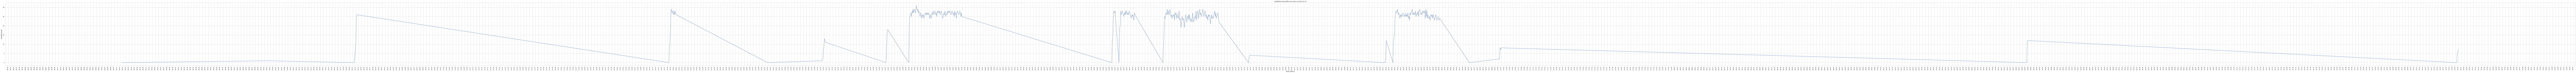

In [184]:
print('plot satellite counts')
raw_trip_analysis_plot(df_satCount_raw, 'satelliteCount', pid, trip_date, jira_trip_id, work_dir)

plot accuracy


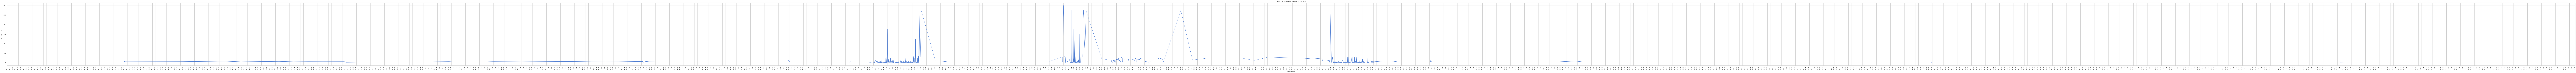

In [185]:
print('plot accuracy')
raw_trip_analysis_plot(df_locChange_raw[['accuracy']], 'accuracy', pid, trip_date, jira_trip_id, work_dir)

plot bool_gps


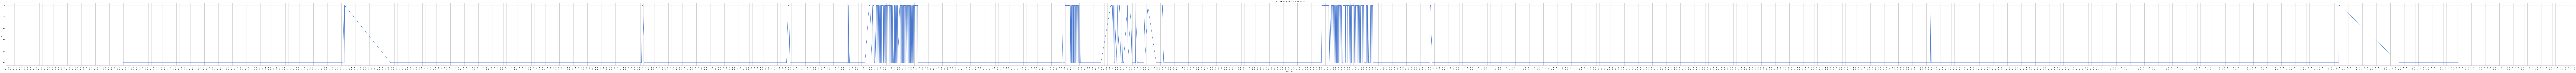

In [186]:
print('plot bool_gps')
raw_trip_analysis_plot(df_locChange_raw, 'bool_gps', pid, trip_date, jira_trip_id, work_dir)

plot accuracy vs network provider


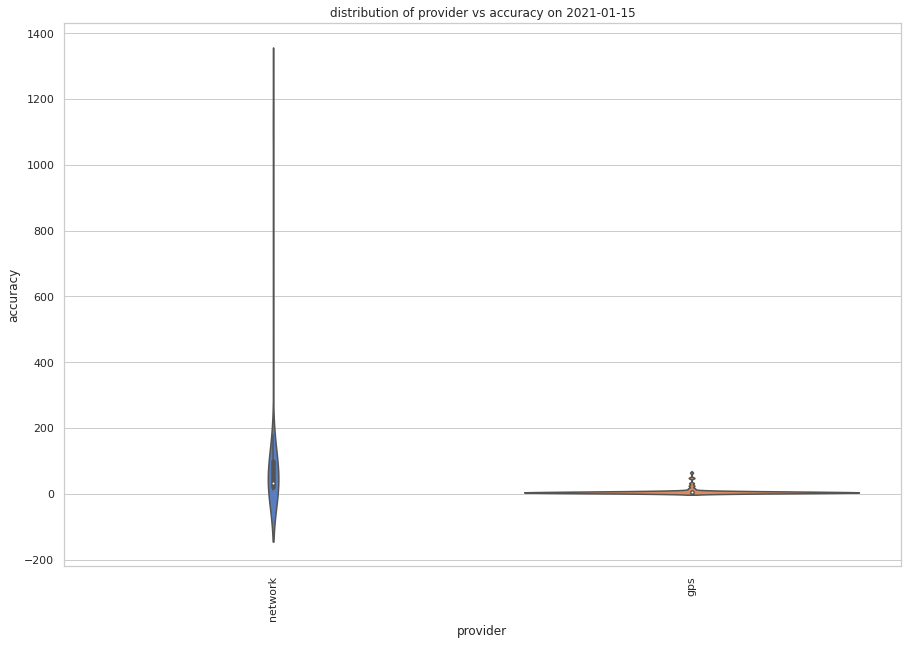

In [187]:
print('plot accuracy vs network provider')
plot_category_distribution(df_locChange_raw, 'provider', 'accuracy', pid, trip_date, 9, work_dir)